In [1]:
%load_ext autoreload
%autoreload 2
import sys
# do this to be able to import the custom python scripts
sys.path.insert(1, "../../../python_scripts")
import os

import recordlinkage as rl
from recordlinkage import preprocessing
from recordlinkage.datasets import load_febrl1, load_febrl2, load_febrl3, load_febrl4

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import dm_diagnostics as dmd
import dm_utils
import dm_file_checker

from itertools import combinations

import json

import dedupe
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

RANDOM_SEED = 1001

## Get Appropriate Filepaths

In [2]:
saved_files_path = "../../../saved_files"
task_name = os.path.basename(os.getcwd())
    
# files to be read in
unlabeled_data_filepath = dm_file_checker.get_proper_unlabeled_data_filepath(task_name, saved_files_path)
mapped_records_filepath =  dm_file_checker.get_filepath(task_name, "mapped_records", saved_files_path)
labeled_pair_ids_filepath =  dm_file_checker.get_filepath(task_name, "labeled_pair_ids", saved_files_path)

# files to be written out as output
settings_filepath =  dm_file_checker.get_filepath(task_name, "model_settings_test_split", saved_files_path)
labeled_data_filepath = dm_file_checker.get_filepath(task_name, "labeled_data_test_split", saved_files_path)

numeric_fields = dm_file_checker.get_dataset_info(task_name, "numeric_fields", saved_files_path)
RECALL_TRAIN_VAL = dm_file_checker.get_task_info(task_name, "recall_train", saved_files_path)
print("Using recall value of {}".format(RECALL_TRAIN_VAL))
print("Numeric fields are {}".format(numeric_fields))

Using recall value of 1.0
Numeric fields are []


## Define parameters for model

In [3]:
# default blocked_proportion is 50%
BLOCKED_PROPORTION = 0.5
# default sample size is 15000
#SAMPLE_SIZE = 30_000
SAMPLE_SIZE = 15_000

## Setup: Reading in Labeled Data

In [4]:
# reading in unlabeled_data
unlabeled_data = dm_utils.read_unlabeled_data_json(unlabeled_data_filepath, numeric_fields = numeric_fields)


converting 190 empty string values of column date_of_birth to None
converting 156 empty string values of column given_name to None
converting 79 empty string values of column surname to None
converting 245 empty string values of column street_number to None
converting 154 empty string values of column address_1 to None
converting 693 empty string values of column address_2 to None
converting 85 empty string values of column suburb to None
converting 0 empty string values of column postcode to None
converting 85 empty string values of column state to None
converting 0 empty string values of column soc_sec_id to None


## Train Test Split of Labeled Data

In [5]:
labeled_pair_ids_df = pd.read_csv(labeled_pair_ids_filepath, dtype = str)
labeled_pair_ids_df.head()

,record id 1,record id 2,label
0,febrl3-rec-1953-dup-3,febrl3-rec-1260-dup-0,distinct
1,febrl3-rec-1623-dup-2,febrl3-rec-669-dup-2,distinct
2,febrl3-rec-278-dup-1,febrl3-rec-1779-dup-0,distinct
3,febrl3-rec-1390-org,febrl3-rec-1029-dup-2,distinct
4,febrl3-rec-546-dup-3,febrl3-rec-1875-org,distinct


In [6]:
#sampling based on random split (may not be advisable because of active learning's sampling methodology)
labeled_pair_ids_train, labeled_pair_ids_test = train_test_split(labeled_pair_ids_df,
                                                                 test_size = 0.2,  
                                                                 random_state = RANDOM_SEED)
labeled_pair_ids_train = labeled_pair_ids_train.copy()
labeled_pair_ids_test = labeled_pair_ids_test.copy()
print(labeled_pair_ids_train.shape, labeled_pair_ids_test.shape)

(100, 3) (26, 3)


In [7]:
dm_utils.write_training_set_from_pairs(labeled_pair_ids_train, labeled_data_filepath, unlabeled_data)

## Retraining Model

In [8]:

fields = dm_file_checker.get_task_info(task_name, "fields", saved_files_path)
print("Using the following fields for the model")
print(fields)

deduper = dedupe.Dedupe(fields, num_cores = 4)


Using the following fields for the model
[{'field': 'street_number', 'type': 'ShortString', 'has missing': True}, {'field': 'postcode', 'type': 'ShortString'}, {'field': 'state', 'type': 'ShortString', 'has missing': True}, {'field': 'soc_sec_id', 'type': 'ShortString'}, {'field': 'given_name', 'type': 'String', 'has missing': True}, {'field': 'surname', 'type': 'String', 'has missing': True}, {'field': 'address_1', 'type': 'String', 'has missing': True}, {'field': 'address_2', 'type': 'String', 'has missing': True}, {'field': 'suburb', 'type': 'String', 'has missing': True}, {'field': 'date_of_birth', 'type': 'DateTime', 'has missing': True, 'fuzzy': False, 'yearfirst': True}]


In [9]:
%%time
dm_utils.prepare_training_deduper(deduper, unlabeled_data, labeled_data_filepath, 
                                  blocked_proportion = BLOCKED_PROPORTION, 
                                  sample_size = SAMPLE_SIZE)

INFO:dedupe.api:reading training from file


reading labeled examples from  ../../../saved_files/dedup-febrl3/test_split_output/labeled_data.json


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (commonThreeTokens, address_2), SimplePredicate: (commonTwoTokens, suburb))
INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (sortedAcronym, postcode), SimplePredicate: (wholeFieldPredicate, date_of_birth))
INFO:dedupe.training:(SimplePredicate: (doubleMetaphone, suburb), SimplePredicate: (sameThreeCharStartPredicate, given_name))
INFO:dedupe.training:(SimplePredicate: (firstTokenPredicate, address_1), SimplePredicate: (sortedAcronym, address_2))


CPU times: user 1min 57s, sys: 1.63 s, total: 1min 59s
Wall time: 2min 16s


In [10]:
%%time
# Using the examples we just labeled, train the deduper and learn blocking predicates
deduper.train(recall = RECALL_TRAIN_VAL)

dm_utils.save_trained_deduper(deduper, labeled_data_filepath, settings_filepath)

INFO:rlr.crossvalidation:using cross validation to find optimum alpha...
INFO:rlr.crossvalidation:optimum alpha: 1.000000, score 0.9403430774111937
INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (sortedAcronym, postcode), SimplePredicate: (wholeFieldPredicate, date_of_birth))
INFO:dedupe.training:(SimplePredicate: (doubleMetaphone, suburb), SimplePredicate: (sameThreeCharStartPredicate, given_name))
INFO:dedupe.training:(SimplePredicate: (firstTokenPredicate, address_1), SimplePredicate: (sortedAcronym, address_2))


CPU times: user 26 s, sys: 438 ms, total: 26.4 s
Wall time: 32.6 s


In [11]:
deduper.predicates

((SimplePredicate: (sortedAcronym, postcode),
  SimplePredicate: (wholeFieldPredicate, date_of_birth)),
 (SimplePredicate: (doubleMetaphone, suburb),
  SimplePredicate: (sameThreeCharStartPredicate, given_name)),
 (SimplePredicate: (firstTokenPredicate, address_1),
  SimplePredicate: (sortedAcronym, address_2)))

## Model Weights

In [12]:
# checking model weights
model_weights = dm_utils.get_model_weights(deduper)
model_weights

,variable,logistic_reg_weight
0,(soc_sec_id: ShortString),-1.010969e+00
1,(suburb: String),-7.866343e-01
2,(postcode: ShortString),-6.732775e-01
3,(given_name: String),-5.603799e-01
4,(address_2: String),-4.959024e-01
5,(state: ShortString),-4.716288e-01
6,(street_number: ShortString),-3.753769e-01
7,(address_1: String),-2.160684e-01
8,(surname: String),-1.950258e-01
9,(days: Derived),-2.133609e-02


## Assessing Blocking on Labeled Data (Test Set)

In [13]:
labeled_true_links = labeled_pair_ids_test.loc[labeled_pair_ids_test["label"] == "match",:]\
                                            .set_index(["record id 1", "record id 2"]).index
labeled_true_links = labeled_true_links.map(lambda x: tuple(sorted(x)))

In [14]:
labeled_rec_ids = labeled_pair_ids_test["record id 1"].unique().tolist() + labeled_pair_ids_test["record id 2"].unique().tolist()

labeled_pairs_data = {rec_id:unlabeled_data[rec_id] for rec_id in labeled_rec_ids}

labeled_candidate_pairs = dm_utils.get_deduper_candidate_pairs(deduper, labeled_pairs_data)
labeled_candidate_pairs = labeled_candidate_pairs.map(lambda x: tuple(sorted(x)))

In [15]:
dmd.diagnose_indexing(labeled_true_links, labeled_candidate_pairs)

Pairs Completeness Ratio
92.31%
Pairs Quality Ratio
92.31%


In [16]:
labeled_true_links

MultiIndex([('febrl3-rec-1490-dup-0',   'febrl3-rec-1490-org'),
            ('febrl3-rec-1621-dup-0', 'febrl3-rec-1621-dup-3'),
            ( 'febrl3-rec-941-dup-3',  'febrl3-rec-941-dup-4'),
            ('febrl3-rec-1708-dup-1', 'febrl3-rec-1708-dup-3'),
            ('febrl3-rec-1990-dup-4',   'febrl3-rec-1990-org'),
            ('febrl3-rec-1217-dup-1', 'febrl3-rec-1217-dup-2'),
            ( 'febrl3-rec-688-dup-0',  'febrl3-rec-688-dup-1'),
            ('febrl3-rec-1418-dup-0', 'febrl3-rec-1418-dup-2'),
            ('febrl3-rec-1725-dup-1', 'febrl3-rec-1725-dup-2'),
            ('febrl3-rec-1648-dup-0', 'febrl3-rec-1648-dup-2'),
            ('febrl3-rec-1534-dup-2', 'febrl3-rec-1534-dup-3'),
            ('febrl3-rec-1694-dup-1', 'febrl3-rec-1694-dup-3'),
            ( 'febrl3-rec-375-dup-1',  'febrl3-rec-375-dup-2')],
           names=['record id 1', 'record id 2'])

In [17]:
labeled_candidate_pairs

MultiIndex([( 'febrl3-rec-941-dup-3',  'febrl3-rec-941-dup-4'),
            ('febrl3-rec-1217-dup-1', 'febrl3-rec-1217-dup-2'),
            ('febrl3-rec-1725-dup-1', 'febrl3-rec-1725-dup-2'),
            ('febrl3-rec-1648-dup-0', 'febrl3-rec-1648-dup-2'),
            ('febrl3-rec-1490-dup-0',   'febrl3-rec-1490-org'),
            ('febrl3-rec-1621-dup-0', 'febrl3-rec-1621-dup-3'),
            ( 'febrl3-rec-438-dup-0',  'febrl3-rec-865-dup-0'),
            ('febrl3-rec-1708-dup-1', 'febrl3-rec-1708-dup-3'),
            ('febrl3-rec-1990-dup-4',   'febrl3-rec-1990-org'),
            ( 'febrl3-rec-688-dup-0',  'febrl3-rec-688-dup-1'),
            ('febrl3-rec-1418-dup-0', 'febrl3-rec-1418-dup-2'),
            ('febrl3-rec-1694-dup-1', 'febrl3-rec-1694-dup-3'),
            ( 'febrl3-rec-375-dup-1',  'febrl3-rec-375-dup-2')],
           )

In [18]:
df = pd.DataFrame.from_dict(unlabeled_data, orient = "index")
fields_list = df.columns.tolist()

dmd.diagnose_link_errors(labeled_true_links, labeled_candidate_pairs, df, fields_list, 
                    similarity_df = None, error_type = "missed_true_links")

Returning missed_true_links


,,address_1_1,address_1_2,address_2_1,address_2_2,date_of_birth_1,date_of_birth_2,given_name_1,given_name_2,postcode_1,postcode_2,soc_sec_id_1,soc_sec_id_2,state_1,state_2,street_number_1,street_number_2,suburb_1,suburb_2,surname_1,surname_2
rec_id_1,rec_id_2,,,,,,,,,,,,,,,,,,,,
febrl3-rec-1534-dup-2,febrl3-rec-1534-dup-3,fawknerstreet,fawkner street,emerald agrigultural college,emerald agrigultural college,None,None,isabella,isabella,6154,6154,6097070,6097070,nsw,nsw,8,8,pottsvklle,pottsville,rundle,runudle


## Assessing Classification on Labeled Data (Test Set)

In [19]:
threshold = 0.5

In [20]:
labeled_all_links = labeled_pair_ids_test.set_index(["record id 1", "record id 2"]).index

In [21]:
candidates = dm_utils.convert_rl_to_dedupe_candidate_pair(labeled_all_links, unlabeled_data)
candidate_scores = dedupe.core.scoreDuplicates(candidates, deduper.data_model, deduper.classifier, deduper.num_cores)
labeled_pair_ids_test["score"] = candidate_scores["score"]
labeled_pair_ids_test["predicted label"] = labeled_pair_ids_test["score"].apply(lambda x: "match" if x > threshold else "distinct")
labeled_pair_ids_test.head()

,record id 1,record id 2,label,score,predicted label
20,febrl3-rec-434-org,febrl3-rec-1684-org,distinct,0.000007,distinct
79,febrl3-rec-1490-org,febrl3-rec-1490-dup-0,match,0.997316,match
3,febrl3-rec-1390-org,febrl3-rec-1029-dup-2,distinct,0.003180,distinct
45,febrl3-rec-1543-dup-0,febrl3-rec-638-dup-0,distinct,0.000193,distinct
89,febrl3-rec-1621-dup-3,febrl3-rec-1621-dup-0,match,0.998312,match


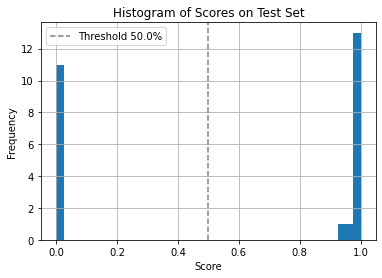

In [22]:
fig, ax = plt.subplots()
labeled_pair_ids_test["score"].hist(bins = 40, ax = ax)
ax.set_xlabel("Score")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Scores on Test Set")
ax.axes.axvline(x = threshold, linestyle = "--", color = "grey", label = "Threshold {:.1f}%".format(threshold*100))
ax.legend()
plt.show()

In [23]:
y_true = labeled_pair_ids_test["label"]
y_pred = labeled_pair_ids_test["predicted label"]
print("Confusion Matrix\n{}".format(confusion_matrix(y_true, y_pred, labels = ["match", "distinct"])))
print("Accuracy Score {:.1f}%".format(accuracy_score(y_true, y_pred)*100))

Confusion Matrix
[[13  0]
 [ 2 11]]
Accuracy Score 92.3%
